In [ ]:
!nvidia-smi

Tue Jul  5 07:09:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/phd-thesis/
!ls

Mounted at /content/gdrive
gdrive	sample_data
/content/gdrive/My Drive/phd-thesis
 adasyn_TL_MajorVoting_balance.ipynb
 ADASYN_TL_MajorVoting_imb.ipynb
 adasyn_xgboost_20_imb.ipynb
 adasyn_xgboost_20.ipynb
 adasyn_xgboost_fulldata_balance.ipynb
 adasyn_xgboost_fulldata_imb.ipynb
 Attack_Types.csv
'bagging&ensemble.py'
 cnn.docx
 cnn.ipynb
 CNN-test-data
 CNN-test-data-balanced
 CNN-test-data-balanced-dropout
 CNN-test-data-imb
 createCNN_Balanced_fulldata.ipynb
 createCNN_Balanced.ipynb
 createNetwork-211025.py
 createNetwork-CNN-imb.ipynb
'createNetwork-testdata (1).ipynb'
 createNetwork-testdata.ipynb
 createNetwork-testdata.py
 ensemble_balance-old.ipynb
 ensemble_imb-old.ipynb
 Evaluate_adasyn_xgboost_fulldata_balance.ipynb
 Evaluate_adasyn_xgboost_fulldata_imb.ipynb
 Evaluate_adasyn_xgboost_model_20.ipynb
 evaluate_auc_3Algorithm_macro.ipynb
 evaluate_auc_3Algorithm_micro.ipynb
 Evaluate_CNN_Balacanced.ipynb
 Evaluate_CNN_imb.ipynb
 Evaluate_PR_3Algorithms.ipynb
 Evaluate_PR_CNN.i

In [2]:
pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 39 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  8 11:13:03 2022

load adasyn and xgbboost balanced model, test on 20% test dataset and evaluate
try using ROC curve
@author: Administrator
"""
# import joblib
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, \
    classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

#testing dataset 20%
#test_x = pd.read_csv('KDDTest_x_20.csv',header=None)
#test_Y = pd.read_csv('KDDTest_y_20.csv',header=None)
test_x = pd.read_csv('KDDTest_x.csv',header=None)
test_Y = pd.read_csv('KDDTest_y.csv',header=None)
test_x.drop(test_x.columns[[115,116,117]], axis=1, inplace=True)   #drop 3 columns

test_Y[0]=list(test_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))
print("test_x", test_x.head())
print("test_y", test_Y.head())

test_Y  = test_Y.values.ravel()
print('original dataset shape %s' % Counter(test_Y))

# load model
#xgboost
clf = xgb.XGBClassifier()
clf.load_model("myXgb_adasyn.json")

#voting
import joblib
clf_vt = joblib.load("VotingClassifier.pkl")

#CNN
from tensorflow import keras
import tensorflow as tf
model = tf.keras.models.load_model('CNN-test-data-balanced')
class_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
class_names_num = ['0', '1', '2', '3', '4']


# after tomek link 
yy = clf.predict_proba(test_x)  #xgboost
yy_vt = clf_vt.predict_proba(test_x)  #Voting
yy_cnn = model.predict(test_x)  #CNN
print("yy_cnn", yy_cnn.shape)
#yy_cnn = predict_proba

from sklearn.preprocessing import label_binarize
# plot PR curve
y_bin = label_binarize(test_Y, classes=[0, 1, 2, 3, 4])  #Y_res
n_classes = y_bin.shape[1]

print("y_bin:", y_bin)
print("n_classes:", n_classes)

#lw = 4

test_x         0         1         2    3         4         5         6         7    \
0 -0.110249 -0.007762 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
1 -0.110249 -0.007762 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
2 -0.109481 -0.005551 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
3 -0.110249 -0.007759 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
4 -0.109865 -0.007762 -0.004915    0 -0.089486 -0.007736 -0.095076 -0.027023   

   8         9    ...  105  106  107  108  109  110  111  112  113  114  
0    0 -0.011664  ...    0    0    0    1    0    0    0    0    0    0  
1    0 -0.011664  ...    0    0    0    1    0    0    0    0    0    0  
2    0 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
3    0 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
4    0 -0.011664  ...    0    0    0    0    1    0    0    0    0    0  

[5 rows x 115 columns]
test_y    0
0  1
1  1
2  0
3  2
4  2
origina

In [4]:
# %%
# The average precision score in multi-label settings
# ...................................................
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
#xgboost
precision = dict()
recall = dict()
average_precision = dict()

#voting
precision_vt = dict()
recall_vt = dict()
average_precision_vt = dict()

#cnn
precision_cnn = dict()
recall_cnn = dict()
average_precision_cnn = dict()


#xgboost
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], yy[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], yy[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_bin.ravel(), yy.ravel())
average_precision["micro"] = average_precision_score(y_bin, yy, average="micro")
#voting
for i in range(n_classes):
    precision_vt[i], recall_vt[i], _ = precision_recall_curve(y_bin[:, i], yy_vt[:, i])
    average_precision_vt[i] = average_precision_score(y_bin[:, i], yy_vt[:, i])

# A "micro-average": quantifying score on all classes jointly
precision_vt["micro"], recall_vt["micro"], _ = precision_recall_curve(
    y_bin.ravel(), yy_vt.ravel())
average_precision_vt["micro"] = average_precision_score(y_bin, yy_vt, average="micro")


#cnn
for i in range(n_classes):
    precision_cnn[i], recall_cnn[i], _ = precision_recall_curve(y_bin[:, i], yy_cnn[:, i])
    average_precision_cnn[i] = average_precision_score(y_bin[:, i], yy_cnn[:, i])

# A "micro-average": quantifying score on all classes jointly
precision_cnn["micro"], recall_cnn["micro"], _ = precision_recall_curve(
    y_bin.ravel(), yy_cnn.ravel())
average_precision_cnn["micro"] = average_precision_score(y_bin, yy_cnn, average="micro")

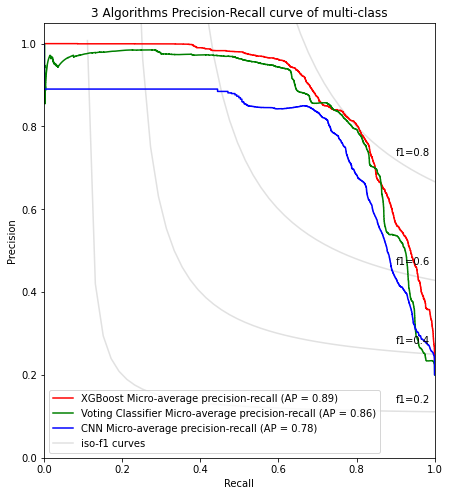

In [6]:
# %%
# Plot Precision-Recall curve for each class and iso-f1 curves
# ............................................................
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import PrecisionRecallDisplay
# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="dimgray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
#xgboost
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="XGBoost Micro-average precision-recall", color="red")
#vt
display = PrecisionRecallDisplay(
    recall=recall_vt["micro"],
    precision=precision_vt["micro"],
    average_precision=average_precision_vt["micro"],
)
display.plot(ax=ax, name="Voting Classifier Micro-average precision-recall", color="green")

display = PrecisionRecallDisplay(
    recall=recall_cnn["micro"],
    precision=precision_cnn["micro"],
    average_precision=average_precision_cnn["micro"],
)
display.plot(ax=ax, name="CNN Micro-average precision-recall", color="blue")


"""
for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)
"""

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("3 Algorithms Precision-Recall curve of multi-class")

plt.show()